In [1]:
%load_ext autoreload
%autoreload 2

%autosave 120

import pandas as pd
import glob
import numpy as np
import os
import json
from modules.utilities import are_bugs_from_tangled, has_bug, is_same_history, parse_hash_delimited_string, has_one_bug

Autosaving every 120 seconds


In [2]:
csv_files = glob.glob("./data/Processed/*.csv")

# True Buggy Methods

In [11]:
true_buggy_methods = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,delimiter="\t")
    for index, row in df.iterrows():
        if has_bug(row["Buggycommiit"]) and is_same_history([row["RiskyCommit"], row["PotentiallyBuggycommit"],row["Buggycommiit"]]) and not are_bugs_from_tangled(row["TangledWMoveandFileRename"], row["Buggycommiit"]):
            true_buggy_methods.append({
                "Project": os.path.basename(csv_file).replace(".csv",""),
                "File": row["file"]
            })

In [12]:
true_buggy_methods = pd.DataFrame(true_buggy_methods)
true_buggy_methods.to_csv("./data/TrueBuggyMethods.csv", index=False)

In [50]:
true_buggy_methods = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,delimiter="\t")
    for index, row in df.iterrows():
        if has_bug(row["Buggycommiit"]) and is_same_history([row["RiskyCommit"], row["PotentiallyBuggycommit"],row["Buggycommiit"]]) and not are_bugs_from_tangled(row["TangledWMoveandFileRename"], row["Buggycommiit"]):
            history = parse_hash_delimited_string(row["Buggycommiit"])
            history.reverse()
            project =  os.path.basename(csv_file).replace(".csv","")
            json_path = os.path.join("./data/source-methods/", project, row["file"])
            data = json.load(open(json_path))

            for index, is_buggy in enumerate(history):
                if is_buggy:
                    try:
                        hash = data["changeHistory"][index]
                        
                        commit_data = data["changeHistoryDetails"][hash]
                        change_data = commit_data["subchanges"][0] if "subchanges" in commit_data.keys() else commit_data

                        if "fix quality flaw" in change_data["commitMessage"].lower() or "fix some quality flaw" in change_data["commitMessage"].lower() or change_data["diff"] == "":
                            continue

                        true_buggy_methods.append(
                            {
                                "Project": project,
                                "File": row["file"],
                                "CommitHash": hash,
                                "Diff": change_data["diff"],
                                "CommitMessage": change_data["commitMessage"],
                                "Decision": "Buggy"
                            }
                        )
                    except:
                        hash = data["changeHistory"][index]
                        print(project, row["file"], hash)
                
true_buggy_gold_set = pd.DataFrame(true_buggy_methods)
true_buggy_gold_set.to_csv("./data/GoldSet_TrueBuggyMethods.csv", index=False)

# True Not-Buggy Methods

In [13]:
true_not_buggy_methods = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,delimiter="\t")
    for index, row in df.iterrows():
        if not has_bug(row["Buggycommiit"]) and is_same_history([row["RiskyCommit"], row["PotentiallyBuggycommit"],row["Buggycommiit"]]):
            true_not_buggy_methods.append({
                "Project": os.path.basename(csv_file).replace(".csv",""),
                "File": row["file"]
            })

In [14]:
true_not_buggy_methods = pd.DataFrame(true_not_buggy_methods)
true_not_buggy_methods.to_csv("./data/TrueNotBuggyMethods.csv", index=False)

In [ ]:
from random import randrange
print(randrange(1,10))

1

In [51]:
p_cnt = 1
true_not_buggy_methods = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,delimiter="\t")
    df = df.sample(frac=1).reset_index(drop=True)
    c_cnt = 0
    limit = 15 if p_cnt <= 47 else 14
    for index, row in df.iterrows():
        if not has_bug(row["Buggycommiit"]) and is_same_history([row["RiskyCommit"], row["PotentiallyBuggycommit"],row["Buggycommiit"]]) and len(parse_hash_delimited_string(row["Buggycommiit"])) > 1:
            history = parse_hash_delimited_string(row["Buggycommiit"])
            history.reverse()
            
            project =  os.path.basename(csv_file).replace(".csv","")
            json_path = os.path.join("./data/source-methods/", project, row["file"])
            data = json.load(open(json_path))

            index = randrange(0, len(history) - 1)
            hash = data["changeHistory"][index]
            
            commit_data = data["changeHistoryDetails"][hash]
            change_data = commit_data["subchanges"][0] if "subchanges" in commit_data.keys() else commit_data
            if change_data["diff"] == "":
                continue

            true_not_buggy_methods.append(
                {
                    "Project": project,
                    "File": row["file"],
                    "CommitHash": hash,
                    "Diff": change_data["diff"],
                    "CommitMessage": change_data["commitMessage"],
                    "Decision": "NotBuggy"
                }
            )
            c_cnt = c_cnt + 1
        if c_cnt == limit:
            break
    p_cnt = p_cnt + 1            
true_not_buggy_gold_set = pd.DataFrame(true_not_buggy_methods)
true_not_buggy_gold_set.to_csv("./data/GoldSet_TrueNotBuggyMethods.csv", index=False)

# Tangled Buggy Methods

In [15]:
tangled_buggy_methods = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file,delimiter="\t")
    for index, row in df.iterrows():
        if has_one_bug(row["Buggycommiit"]) and is_same_history([row["RiskyCommit"], row["PotentiallyBuggycommit"],row["Buggycommiit"]]) and are_bugs_from_tangled(row["TangledWMoveandFileRename"], row["Buggycommiit"]):
            #print(row["file"], row["RiskyCommit"], row["TangledWMoveandFileRename"])
            change_list = parse_hash_delimited_string(row["TangledWMoveandFileRename"])
            change_list.reverse()
            history = parse_hash_delimited_string(row["Buggycommiit"])
            history.reverse()
            
            for index, (change_count, is_buggy) in enumerate(zip(change_list, history)):
                if is_buggy == 1:
                    tangled_buggy_methods.append({
                        "Project": os.path.basename(csv_file).replace(".csv",""),
                        "File": row["file"],
                        "HistoryIndex": index,
                        "FileChangeCount": change_count
                    })

In [16]:
tangled_buggy_methods = pd.DataFrame(tangled_buggy_methods)
tangled_buggy_methods = tangled_buggy_methods[tangled_buggy_methods["FileChangeCount"] > 1]
tangled_buggy_methods = tangled_buggy_methods[tangled_buggy_methods["FileChangeCount"] <=5]
tangled_buggy_methods.to_csv("./data/TangledBuggyMethods.csv", index=False)

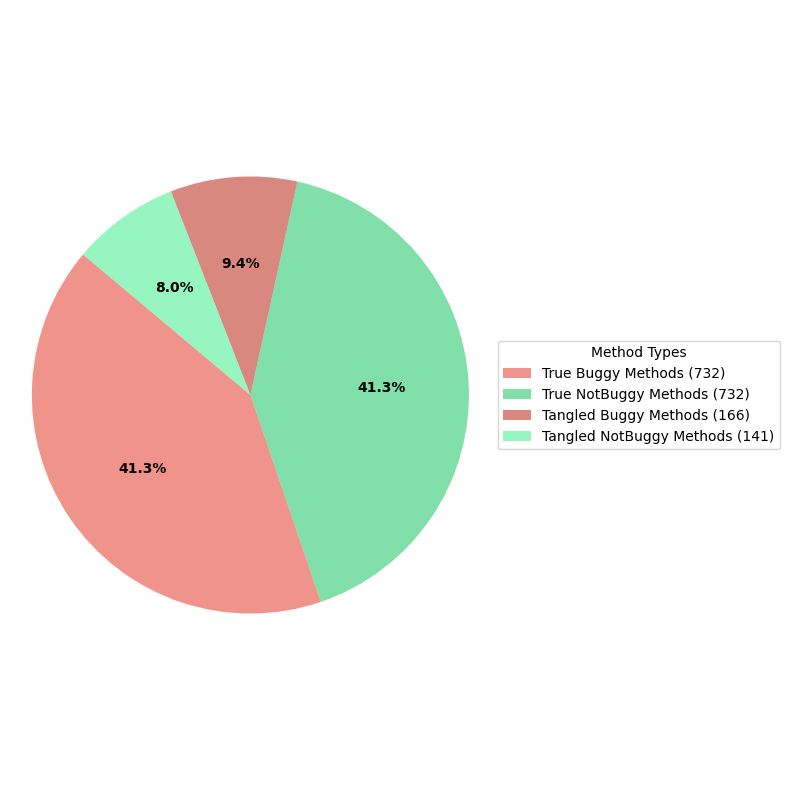

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['True Buggy Methods', 'True NotBuggy Methods', 'Tangled Buggy Methods', 'Tangled NotBuggy Methods']
sizes = [732, 732, 166, 141]

# Combine label with actual value for legend
legend_labels = [f"{label} ({value})" for label, value in zip(labels, sizes)]

# Softer red/green shades with opacity (RGBA)
colors = [
    (231/255, 76/255, 60/255, 0.6),   # Light red
    (46/255, 204/255, 113/255, 0.6),  # Light green
    (192/255, 57/255, 43/255, 0.6),   # Deeper red
    (82/255, 239/255, 150/255, 0.6)   # Deeper green
]

# Create Pie Chart without inside labels
plt.figure(figsize=(8, 8))
wedges, _, autotexts = plt.pie(
    sizes, labels=[None]*len(labels), autopct='%1.1f%%',
    startangle=140, colors=colors
)

# Add a legend with actual values
plt.legend(wedges, legend_labels, title='Method Types', loc='upper right', bbox_to_anchor=(1, 0.5))

# Format percentage text
for text in autotexts:
    text.set_color('black')
    text.set_fontweight('bold')

plt.axis('equal')
plt.tight_layout()
plt.show()
